In [40]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np
import cmath
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

# proper labeling of plots
from matplotlib.ticker import EngFormatter

# some of the functions below have Type annotations
from typing import Tuple

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
def srrc_pulse(a, fsT, N=5):
    r"""Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [6]:
def pop_count32(x: np.uint32) -> np.uint8:
    """count the number of 1s in 32-bit integer x using Wegner's method
    
    Inputs:
    x - a 32 bit integer

    Returns:
    an integer between 0 and 32 indicating the number of 1s in x
    """
    
    count: np.uint8 = 0
    
    while (x > 0):
        x = x & (x-1)
        count += 1
        
    return count

In [7]:
def lfsr_step(state: np.uint32, fb: np.uint32, N: int = 31) -> Tuple[np.uint8, np.uint32]:
    """Single update step of LFSR with feedback connections fb
    
    Inputs:
    * state (uint32): initial state of the feedback shift register
    * fb (uint32): bit map indicating feedback connections; the LSB corresponds to bit 0 in the LFSR
    * N (int) order if the LFSR; must be less than 32 (default: 31)
    
    Returns:
    * elem - next element of the LFSR sequence
    * state - updated state
    
    Example: Generate the first 10 elements of a LFSR sequence with fb=0b1001 and initial state=0b1111
    >>> state = 0b1111
    >>> seq = np.empty(10, dtype=np.uint8)
    >>> for n in range(10):
    >>>     seq[n], state = lfsr31_step(state, 0b1001)
    >>> seq
    
    array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)
    """
    
    # save the LSB before updating state; it will be returned
    elem: np.uint8 = state & 0b1
        
    # update state
    fb_vec: np.uint32 = state & fb
    fb_bit: np.uint8 = (pop_count32(fb_vec) & 0b1)
    
    # insert feedback bit at position N, then shift
    state = (state | fb_bit << N) >> 1
    
    return elem, state

In [8]:
def lfsr(init: np.uint32, fb: np.uint32, M: int, N: int = 31, Nc:int = 0):
    """Compute M samples of a LFSR sequence
    
    Inputs:
    init - initial state of the LFSR
    fb - feedback connection for the LFSR
    M - number of samples to generate
    N - order of the LFSR (default: 31)
    Nc - statrting sample (default 0)

    Returns:
    length-M vector of bits (stored as np.uint8)
    """
    seq = np.empty(M, dtype=np.uint8)

    state = init

    for n in range(Nc):
        _, state = lfsr_step(state, fb, N)          # discard the first Nc

    for n in range(M):  
        seq[n], state = lfsr_step(state, fb, N)     # keep the next Mc

    return seq

In [9]:
def est_freq(Z, pn, L=None):
    """Estimate frequency estimate from preamble samples

    Inputs:
    Z - matched filter outputs for preamble (taken at symbol period)
    pn - preamble sequence (same length as Z)
    L - spacing between samples to measure phase difference (default 2/3*K)

    Returns:
    float - frequency ofsset per symbol period
    """
    K = len(pn)

    if L is None:
        L = (2*K) // 3

    # make an array of all L-spaced phase differences
    dp = np.array( [ (pn[n+L]*Z[n+L]) * np.conj(pn[n]*Z[n]) for n in range(K-L) ] )

    return np.angle(np.mean(dp))/(2*L*np.pi)

In [10]:
class First_Order_Filter():
    """Class representing a first-order loop filter"""

    def __init__(self, alpha):
        """Initialize the gain of the filter
        
        Input:
        alpha - loop gain
        """
        self.alpha = alpha

    def __call__(self, d_n):
        """invoke the filter
        
        Input:
        d_n - single sample, representing error

        Returns:
        filtered sample; type is the same as the input
        """
        return self.alpha * d_n

    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, new_val):
        if new_val < 2 and new_val > 0:
            self._alpha = new_val
        else:        
            raise ValueError("alpha = {:} makes PLL unstable".format(new_val))

In [11]:
class Second_Order_Filter():
    """Class representing a second-order loop filter"""

    def __init__(self, alpha1, alpha2, state=0):
        """Initialize the gains and the state of the filter
        
        Input:
        alpha1 - linear gain
        alpha2 - integrator gain
        state - value held by integrator (optional, default: 0)
        """
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.state = state

    def __call__(self, d_n):
        """invoke the filter
        
        Input:
        d_n - single sample, representing error

        Returns:
        filtered sample; type is the same as the input
        """
        out = self.alpha1 * d_n + self.state
        self.state += self.alpha2 * d_n  # update state
        
        return out

    # below, we check that 0 <= alpha2 < alpha1 < 1
    @property
    def alpha1(self):
        return self._alpha1

    @alpha1.setter
    def alpha1(self, new_val):
        if new_val < 1 and new_val > 0:
            self._alpha1 = new_val
        else:
            raise ValueError("alpha1 = {:} can make PLL unstable".format(new_val))

    @property
    def alpha2(self):
        return self._alpha2

    @alpha2.setter
    def alpha2(self, new_val):
        if new_val < self._alpha1 and new_val > 0:
            self._alpha2 = new_val
        else:
            raise ValueError("alpha2 = {:} can make PLL unstable".format(new_val))

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

    @property
    def damping_factor(self):
        return self.alpha1 / 2 / np.sqrt(self.alpha2) 

In [46]:
class Integrator():
    """Class representing an integrator"""

    def __init__(self, state=0):
        self.state = state

    def __call__(self, x_n):
        "Compute the output from the integrator"
        out = self.state
        self.state += x_n

        return out

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

In [57]:
def complex_correction(Z_n, gamma):
    """
    Apply complex amplitude and phase correction to the input signal.

    Inputs:
    Z_n   - Complex input sample to be corrected
    gamma - Complex gain (alpha * exp(-j*phi))

    Returns:
    Corrected complex sample
    """
    return Z_n * gamma

In [189]:
# Complex Phase Detector Function
def measure_complex_error(X_n, s_n=1+0j):
    """
    Measure the complex amplitude and phase error of the modulated symbol.

    It is assumed that X_n = s_n * (1 / gamma) + N_n, where s_n is the information symbol
    and N_n is noise. The goal is to estimate the error gamma such that gamma * (1 / gamma) = 1

    Inputs:
    X_n - Corrected complex sample
    s_n - Reference information symbol (default: 1)

    Returns:
    Complex error estimate
    """
    if s_n == 0:
        raise ValueError("Reference symbol s_n cannot be zero.")
    return s_n -X_n

    # return 1+0j - X_n / s_n

In [190]:
# Combined Implementation in the Loop for complex amplitude
class Complex_Second_Order_Filter:
    """Class representing a second-order loop filter for complex signals"""

    def __init__(self, alpha1, alpha2, state=0+0j):
        """
        Initialize the gains and the state of the filter

        Input:
        alpha1 - Proportional gain (complex)
        alpha2 - Integrator gain (complex)
        state  - Integrator state (optional, default: 0+0j)
        """
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.state = state

    def __call__(self, error):
        """
        Apply the loop filter to the error
        Input:
        error - Complex error sample
        Returns:
        Filtered complex sample
        """
        out = self.alpha1 * error + self.state
        self.state += self.alpha2 * error  # update state
        return out

In [191]:
alpha1 = 0.1 + 0.1j    
alpha2 = 0.004 + 0.002j  
H = Complex_Second_Order_Filter(alpha1,alpha2)
H(2+0j) 
H.state

(0.008+0.004j)

In [192]:
class Complex_Integrator():
    """Class representing an integrator"""

    def __init__(self, state=0+0j):
        self.state = state

    def __call__(self, x_n):
        "Compute the output from the integrator"
        out = self.state
        self.state += x_n

        return out

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

In [193]:
# quick check that this works: a sequence of 1's integrates into a ramp
S = Complex_Integrator()
x = np.ones(10,dtype=complex)
y = np.zeros_like(x,dtype=complex)
for n in range(10):
    y[n] = S(x[n])

In [194]:
# Loop filter parameters
alpha1 = 0.1 + 0.1j    
alpha2 = 0.004 + 0.002j  

loop_filter = Complex_Second_Order_Filter(alpha1, alpha2)
integrator = Complex_Integrator()
# Number of samples
N = 200
# Reference symbol
s = np.ones(N, dtype=complex) # Assuming unit amplitude and zero phase
dA = np.zeros_like(s, dtype=complex)      # amplitude error
gamma = np.zeros_like(s, dtype=complex)   # estimate of 1/A
state_H = np.zeros_like(gamma) #state of the loop filter
y = np.zeros_like(s,dtype=complex)   # amplitude and phase corrected input


# Part A: Input Signal with complex amplitude error
# Parameters in polar form
A_offset = 1.5  # Amplitude offset
phi_offset = np.pi / 4  # Phase offset (45 degrees)
# Params in cartesian form
A_complex = np.full(N,cmath.rect(A_offset,phi_offset))

SNR_db = 20
SNR = 10**(SNR_db / 10)
noise_var = np.sqrt(SNR/2)

# Generate noise
noise = (np.random.randn(N) + 1j * np.random.randn(N)) * noise_var

# Generate received signal with amplitude and phase offset
Z = s * A_complex + noise

In [197]:
for n in range(N):
    gamma[n] = integrator.state
    # print(gamma[n])
    # Apply correction
    y[n] = complex_correction(Z[n], gamma[n])
    # print(y[n])
    # Measure error
    dA[n] = measure_complex_error(y[n], s[n])
    print(dA[n])
    # Filter the error
    tmp = loop_filter(dA[n])
    # print(tmp)
    try:
        state_H[n] = loop_filter.state
    except AttributeError:
        pass
    integrator(tmp)


(9.249158322412661e+29+1.2075856238213073e+29j)
(1.119017721475057e+30-2.1211933325221914e+30j)
(4.255651558621463e+30+8.888190161702803e+30j)
(2.7068785440057985e+30+6.546014570768549e+30j)
(-4.6523319954295095e+30-4.7468513925888055e+30j)
(-1.2715369810039038e+31+8.052501594787771e+30j)
(1.064873983722064e+31+2.2288238897401673e+31j)
(6.9017895991453985e+31+4.787131252604648e+31j)
(-7.983259289440977e+31-7.970945007331119e+31j)
(-4.8644077226079756e+29+1.6735675015453495e+31j)
(1.4722221580572744e+31+2.4409965107215513e+31j)
(1.9890413923839642e+31-4.639898880716816e+31j)
(1.0688907398564684e+31-2.9300163189614846e+30j)
(-3.2625817284754227e+31-2.8693673274959106e+31j)
(4.456689932369163e+31-1.3191570352471882e+31j)
(-6.018983757273564e+31-4.92295650695848e+31j)
(2.2263675215284788e+31+6.255953345423625e+31j)
(-2.6430060994887163e+31-1.382462555357228e+31j)
(-2.6819084746195593e+31+5.957888300625306e+31j)
(2.6705325430788504e+31-1.0692530770974334e+31j)
(2.1132059307914384e+31+1.5287

/Users/azukachiejina/miniforge3/envs/sionna/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/azukachiejina/miniforge3/envs/sionna/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


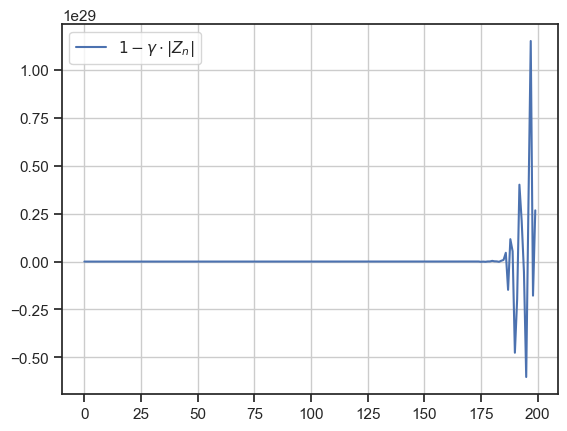

In [196]:
# Verify the error between the true instantenous complex amplitude and estimated amplitude approaches zero
# plt.plot(1/A_complex, label=r'$1/A$')
# plt.plot(gamma, label=r'$\hat{\gamma}$') # 
plt.plot(dA, label=r'$1 - \gamma \cdot |Z_n|$') # Estimated error

plt.grid()
plt.legend()

plt.show()

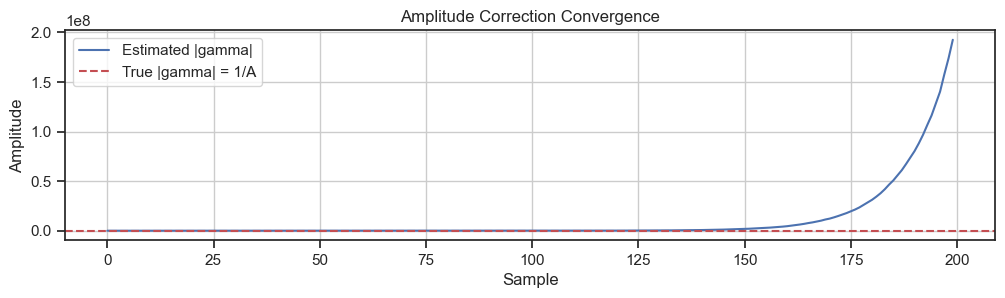

In [18]:
# Plotting the convergence of gamma to 1/A * e^{-j phi}
plt.figure(figsize=(12, 6))

# Amplitude convergence
plt.subplot(2, 1, 1)
plt.plot(np.abs(gamma_est), label='Estimated gamma')
plt.axhline(1 / A_offset, color='r', linestyle='--', label='True |gamma| = 1/A')
plt.title('Amplitude Correction Convergence')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()


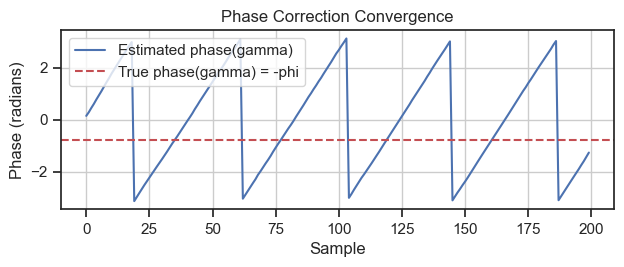

In [19]:
# Phase convergence
plt.subplot(2, 1, 2)
plt.plot(np.angle(gamma_est), label='Estimated phase(gamma)')
plt.axhline(-phi_offset, color='r', linestyle='--', label='True phase(gamma) = -phi')
plt.title('Phase Correction Convergence')
plt.xlabel('Sample')
plt.ylabel('Phase (radians)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

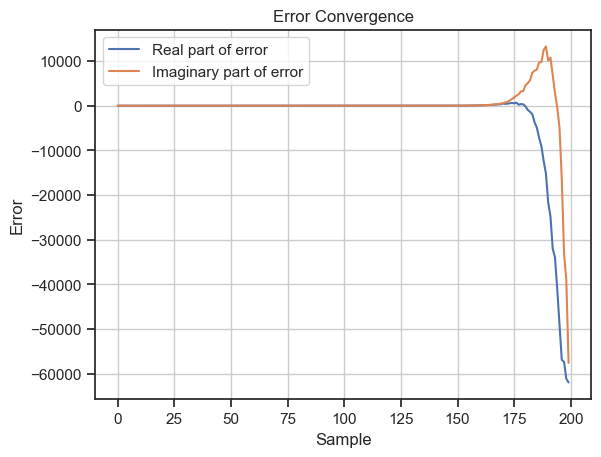

In [27]:
# Verify that errors approach zero
plt.plot(np.real(errors), label='Real part of error')
plt.plot(np.imag(errors), label='Imaginary part of error')
plt.title('Error Convergence')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

In [21]:
# part II: Input Signal with Amplitude, Phase, and Frequency Offset

# Parameters
A_offset = 1.5  # Amplitude offset
phi_offset = np.pi / 4  # Phase offset (45 degrees)
f_offset = 0.01  # Frequency offset (radians per sample)

SNR_db = 20
SNR = 10**(SNR_db / 10)

# Generate noise
noise = (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2 * SNR)

# Generate received signal with amplitude, phase, and frequency offset
phase_sequence = phi_offset + 2 * np.pi * f_offset * np.arange(N)
Z = s * A_offset * np.exp(1j * phase_sequence) + noise

# Reset loop filter and gamma
loop_filter = Complex_Second_Order_Filter(alpha1, alpha2)
gamma_est = np.zeros(N, dtype=complex)
errors = np.zeros(N, dtype=complex)
gamma = 1 + 0j


In [22]:
for n in range(N):
    # Apply correction
    X_n = complex_correction(Z[n], gamma)

    # Measure error
    error = measure_complex_error(X_n, s)
    errors[n] = error

    # Filter the error
    y = loop_filter(error)

    # Update gamma
    gamma = gamma + y

    # Store the estimate
    gamma_est[n] = gamma

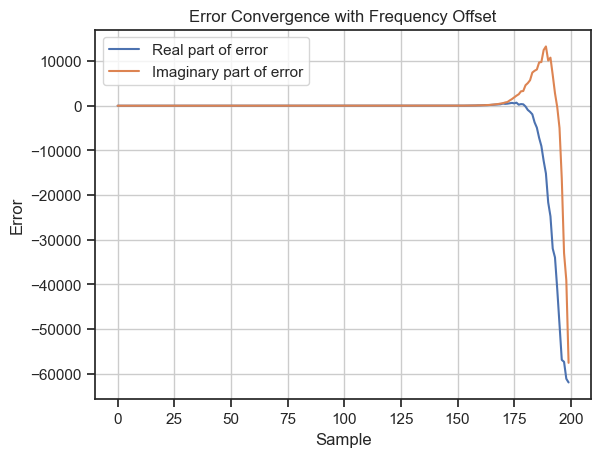

In [28]:
# # Plotting the convergence of gamma to 1/A * e^{-j(phi + 2*pi*f*n)}
# plt.figure(figsize=(12, 6))

# # Amplitude convergence
# plt.subplot(2, 1, 1)
# plt.plot(np.abs(gamma_est), label='Estimated |gamma|')
# plt.axhline(1 / A_offset, color='r', linestyle='--', label='True |gamma| = 1/A')
# plt.title('Amplitude Correction Convergence with Frequency Offset')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid()

# # Phase convergence (should account for frequency offset)
# plt.subplot(2, 1, 2)
# plt.plot(np.angle(gamma_est), label='Estimated phase(gamma)')
# plt.axhline(-phi_offset, color='r', linestyle='--', label='True phase(gamma) = -phi')
# plt.title('Phase Correction Convergence with Frequency Offset')
# plt.xlabel('Sample')
# plt.ylabel('Phase (radians)')
# plt.legend()
# plt.grid()

# plt.tight_layout()
# plt.show()

# Verify that errors approach zero
plt.plot(np.real(errors), label='Real part of error')
plt.plot(np.imag(errors), label='Imaginary part of error')
plt.title('Error Convergence with Frequency Offset')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

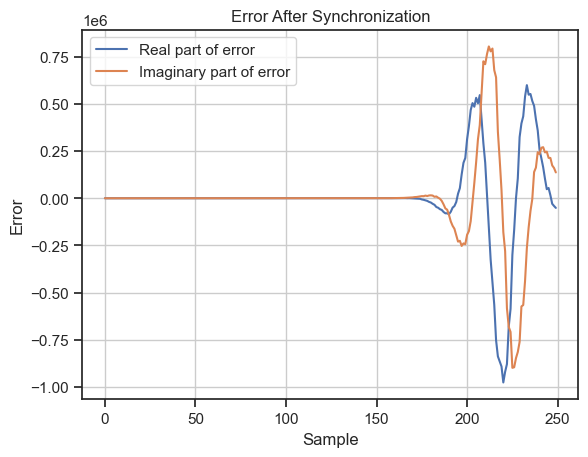

In [32]:
# Complete Synchronization System with Initial Acquisition and Tracking
# Preamble parameters

K = 50  # Number of preamble symbols
preamble_symbols = np.ones(K, dtype=complex)  # Using all ones for simplicity

# Data symbols
M = 200  # Number of data symbols
data_symbols = np.ones(M, dtype=complex)  # Using all ones for simplicity

# Total symbols
symbols = np.concatenate([preamble_symbols, data_symbols])

# Total number of samples
N = K + M
# Offsets
A_offset = 1.5      # Amplitude offset
phi_offset = np.pi / 4  # Phase offset (45 degrees)
f_offset = 0.005    # Frequency offset (radians per sample)

SNR_db = 20
SNR = 10**(SNR_db / 10)

# Generate noise
noise = (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2 * SNR)

# Generate received signal with amplitude, phase, and frequency offsets
phase_sequence = phi_offset + 2 * np.pi * f_offset * np.arange(N)
Z = symbols * A_offset * np.exp(1j * phase_sequence) + noise
# Extract preamble samples
Z_preamble = Z[:K]

# Estimate initial amplitude and phase offsets
# Assuming no frequency offset during acquisition for simplicity
A_est_initial = np.mean(np.abs(Z_preamble))
phi_est_initial = np.angle(np.mean(Z_preamble))

# Estimate initial frequency offset (optional)
# Using linear regression on the phase of preamble
phases = np.angle(Z_preamble)
n = np.arange(K)
A_freq = np.vstack([n, np.ones(K)]).T
f_est_initial, _ = np.linalg.lstsq(A_freq, phases, rcond=None)[0]

# Initialize complex gain gamma based on initial estimates
gamma_initial = 1 / A_est_initial * np.exp(-1j * phi_est_initial)

# Initialize loop filter states
# For the complex second-order filter, we can set the initial state to gamma_initial
loop_filter = Complex_Second_Order_Filter(alpha1, alpha2, state=gamma_initial)

# Initialize integrators (if separate integrators are used)
# In this implementation, the loop filter handles the integrator state
# Storage for results
gamma_est = np.zeros(N, dtype=complex)
gamma_est[:K] = gamma_initial  # Assign initial estimates to preamble

for n in range(K, N):
    # Apply correction
    X_n = complex_correction(Z[n], gamma_initial)

    # Measure error
    error = measure_complex_error(X_n, symbols[n])

    # Filter the error
    y = loop_filter(error)

    # Update gamma
    gamma_initial = gamma_initial + y

    # Store the estimate
    gamma_est[n] = gamma_initial
# True gamma over time (assuming frequency offset)
true_gammas = 1 / A_offset * np.exp(-1j * (phi_offset + 2 * np.pi * f_offset * np.arange(N)))

# # Plot amplitude convergence
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(np.abs(gamma_est), label='Estimated |gamma|')
# plt.plot(np.abs(true_gammas), label='True |gamma|', linestyle='--')
# plt.title('Amplitude Correction with Initial Acquisition')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid()

# # Plot phase convergence
# plt.subplot(2, 1, 2)
# plt.plot(np.angle(gamma_est), label='Estimated Phase(gamma)')
# plt.plot(np.angle(true_gammas), label='True Phase(gamma)', linestyle='--')
# plt.title('Phase Correction with Initial Acquisition')
# plt.xlabel('Sample')
# plt.ylabel('Phase (radians)')
# plt.legend()
# plt.grid()

# plt.tight_layout()
# plt.show()

# Plot error convergence
errors = Z * gamma_est  # Corrected signal
error_metrics = errors / symbols
plt.plot(np.real(error_metrics), label='Real part of error')
plt.plot(np.imag(error_metrics), label='Imaginary part of error')
plt.title('Error After Synchronization')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()